In [1]:
from fastai.vision import *
from fastai.tabular import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
pwd

'/home/ab/Projects/wine_quality'

In [5]:
data_path = Path('wine_quality')

In [6]:
train_df = pd.read_csv('red_wines_ab.csv')
print(len(train_df))

1599


In [7]:
train_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
train_df['quality'].value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [9]:
train_df['quality'] = train_df['quality'].replace([3,4,5,6,7,8,],[0,0,0,1,1,1])

In [10]:
train_df['quality'].value_counts(normalize=True)

1    0.534709
0    0.465291
Name: quality, dtype: float64

In [11]:
train_df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

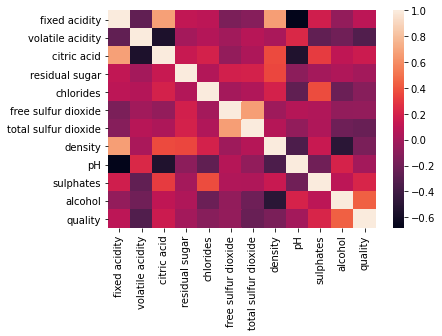

In [12]:
sns.heatmap(train_df.corr())

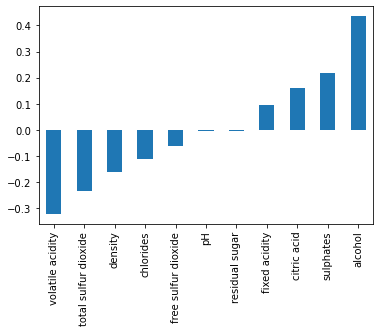

In [13]:
train_df.corr()['quality'][:-1].sort_values().plot(kind='bar')

In [14]:
train_df['quality'] = train_df['quality'].replace([0,1],['Good', 'Excellent'])

In [15]:
def get_valid_index(df, valid_pct:float=0.2, seed:int=0):
    np.random.seed(seed)
    rand_idx = np.random.permutation(range_of(df))
    cut = int(valid_pct * len(df))
    val_idx = rand_idx[:cut]
    return val_idx

val_idx = get_valid_index(train_df)
len(val_idx)

319

In [16]:
train_df = train_df.drop(['residual sugar','pH'], axis=1)

In [17]:
dep_var = 'quality'
cat_names = []
cont_names = ['fixed acidity','volatile acidity','chlorides',
              'total sulfur dioxide','density','sulphates',
              'alcohol', 'citric acid','free sulfur dioxide']
procs = [FillMissing, Categorify, Normalize]
bs=64

In [18]:
tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names,
            cont_names=cont_names, procs=procs)
            .split_by_idx(val_idx)
            .label_from_df(cols=dep_var)
            .databunch(bs=bs))

In [19]:
tab_data.show_batch(rows=5)

fixed acidity,volatile acidity,chlorides,total sulfur dioxide,density,sulphates,alcohol,citric acid,free sulfur dioxide,target
-0.7711,0.3295,-0.7332,-1.1636,-0.4017,-1.0812,-0.1087,-1.3923,-1.2375,Good
0.3245,0.3295,0.1667,-0.7468,0.9795,-0.4519,-0.1087,0.6018,-1.0475,Good
-1.5783,0.0557,-0.7959,-1.0148,-1.3579,-0.4519,0.9269,-1.1878,-1.0475,Good
-0.6558,0.9047,-0.2309,-0.8064,-0.6885,-0.6807,-0.2970,-0.7276,-0.3823,Good
0.1515,-0.2182,7.0101,0.4441,0.6077,2.9233,-1.3326,1.2154,-0.0022,Good


In [20]:
learn = tabular_learner(tab_data, layers=[200,100], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


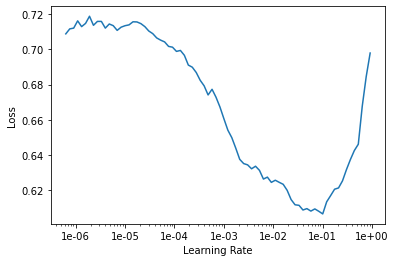

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.665519,0.650510,0.605016,00:00
1,0.617007,0.573382,0.670846,00:00
2,0.580473,0.532830,0.702194,00:00
3,0.554718,0.516628,0.736677,00:00
4,0.534740,0.506143,0.739812,00:00
5,0.520091,0.502050,0.730408,00:00
6,0.508388,0.503094,0.736677,00:00
7,0.496677,0.491899,0.755486,00:00
8,0.485630,0.494666,0.749216,00:00
9,0.475046,0.495166,0.752351,00:00


In [23]:
interp = ClassificationInterpretation.from_learner(learn)

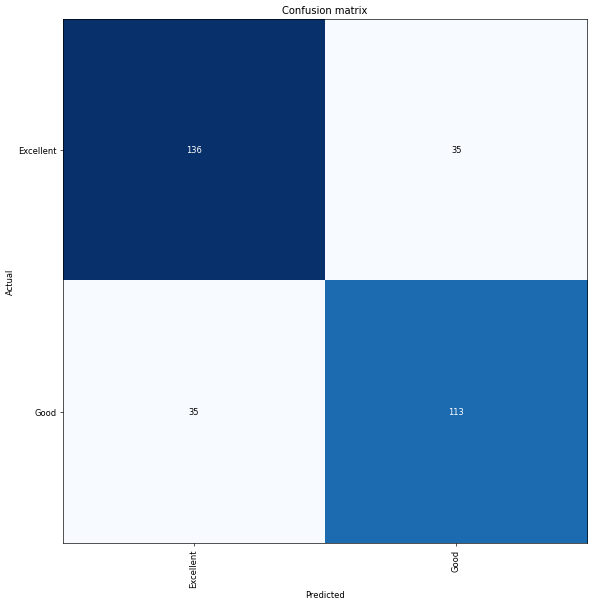

In [24]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)